# Finding RNA-seq control genes

Tong Shu Li

In this notebook we will perform a meta-analysis of multiple datasets to find genes which have relatively constant expression across different biological conditions and times. These genes will be used as controls during RNA-seq.

### Desirable properties

The genes we want for use as RNA-seq controls have the following desirable properties:

1. **Medium expression**. Highly expressed genes will consume too many RNA-seq reads, while lowly expressed genes will be harder to detect consistently.
2. **Unchanging expression**. We want genes which give a relatively constant expression value across different conditions and times.

To ensure that we can compare expression values across different conditions and experiments, we will look at the gene's expression percentile in the sample (i.e. its expression in relation to other genes). It will not be meaningful to directly compare the expression values (RNAseq counts per million, log2 of microarray intensity) across different conditions, because the dynamic ranges of the values in each sample may be different, the distributions of expression values may change, etc.

This will also allow us to compare between RNA-seq and microarray datasets, since the values of expression from these two experimental methods are not directly comparable.

To summarize, we will look for "marker" genes which are expected to be consistently at the $X$ percentile of expression within a sample across different datasets, conditions, and timepoints.

## Plan

When we estimate a gene's expression percentile, we want to retain the maximum number of measurements at the time of calculation to give a better estimate of the overall expression percentile in the entire transcriptome. This means that if a gene (WormBase id) was measured by multiple Affy probes, then we will calculate the expression percentile for each probe, and then aggregate the results by WormBase id.

To determine the constant expression genes, we will:
1. Calculate the expression percentile for each probe (if microarray), and each gene (WormBase id) if RNA-seq.
2. Aggregate expression by gene (WormBase id).
3. Calculate mean expression percentile and variance of expression percentile.
4. Rank results and look for the genes with lowest variance at each expression percentile.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys

In [2]:
sys.path.append("../..")

In [3]:
from src.plots import plot_multi_density
from src.stats import calc_percentile

In [4]:
%matplotlib inline

---

## Datasets under examination

We will use the following datasets to find our constant reference genes:

1. **GSE21784**: a C. elegans timeseries using the GPL200 microarray platform.
2. **GSE77110**: a C. elegans timeseries using the GPL200 microarray platform.
3. **PMID26623667**: a C. elegans timeseries using RNA-seq.

Since the genes in PMID26623667 are identified primarily by WormBase identifiers, we will drop any GPL200 probes which do not map to WormBase ids.

## Read PMID26623667

In [5]:
mian = (
    pd.read_csv("../../data/PMID26623667/clean_annotated_cpm_values.tsv", sep = '\t')
        .assign(log_cpm = lambda df: np.log(df["cpm_value"]))
        .rename(columns = {"wormbaseid": "wormbase_id"})
        .drop(["youngref_cpm", "RLFEC"], axis = 1)
)

In [6]:
mian.shape

(391644, 12)

In [7]:
mian.head()

,seqname,samples,cpm_value,cohort,replicate,day_harvested,drug,drug_conc_uM,day_drug_added,wormbase_id,gene_symbol,log_cpm
0,2RSSE.1,11,4.55942,1,1,1,water,0,1,WBGene00007064,2RSSE.1,1.517195
1,2RSSE.1,12,3.21332,1,2,1,water,0,1,WBGene00007064,2RSSE.1,1.167305
2,2RSSE.1,13,4.54444,1,3,1,water,0,1,WBGene00007064,2RSSE.1,1.513905
3,2RSSE.1,21,11.43680,2,1,3,water,0,1,WBGene00007064,2RSSE.1,2.436836
4,2RSSE.1,22,4.77467,2,2,3,water,0,1,WBGene00007064,2RSSE.1,1.563325


In [8]:
mian.groupby("samples")["wormbase_id"].nunique().value_counts()

10879    36
Name: wormbase_id, dtype: int64

Each of the 36 samples (3 replicates of 12 conditions) measured expression for 10879 unique genes.

## Read GPL200 id mapping

Read the probe to WormBase id mapping for GPL200.

In [9]:
gpl200 = pd.read_csv("../../data/GPL_maps/GPL200_wormbase_map.tsv", sep = '\t')

In [10]:
gpl200.shape

(20841, 2)

In [11]:
gpl200.head()

,probe_id,wormbase_id
0,187171_s_at,WBGene00000001
1,192458_at,WBGene00000002
2,190092_at,WBGene00000003
3,190053_at,WBGene00000004
4,190396_s_at,WBGene00000005


In [12]:
gpl200["probe_id"].nunique()

20575

In [13]:
gpl200["wormbase_id"].nunique()

17281

An Affy probe may potentially map to multiple WormBase ids (more unique probe ids than WormBase ids).

## Read GSE21784

In [14]:
exp_mjy = pd.read_csv("../../data/GSE21784/annot_GSE21784.tsv", sep = '\t')

In [15]:
exp_mjy.shape

(203625, 6)

In [16]:
exp_mjy.head()

,probe_id,geo_id,log2_exp,age,days_old,replicate
0,171720_x_at,GSM542652,8.71,L4 larvae,0,1
1,171721_x_at,GSM542652,9.91,L4 larvae,0,1
2,171722_x_at,GSM542652,11.28,L4 larvae,0,1
3,171723_x_at,GSM542652,12.97,L4 larvae,0,1
4,171724_x_at,GSM542652,8.26,L4 larvae,0,1


In [17]:
exp_mjy["probe_id"].nunique()

22625

## Read GSE77110

In [18]:
exp_hou = pd.read_csv("../../data/GSE77110/annot_GSE77110.tsv", sep = '\t')

In [19]:
exp_hou.shape

(339375, 6)

In [20]:
exp_hou.head()

,probe_id,geo_id,log2_exp,sample,days_old,diet
0,171720_x_at,GSM2044469,8.717144,N2_AL_AD2,2,AL
1,171721_x_at,GSM2044469,11.016367,N2_AL_AD2,2,AL
2,171722_x_at,GSM2044469,11.863110,N2_AL_AD2,2,AL
3,171723_x_at,GSM2044469,14.501900,N2_AL_AD2,2,AL
4,171724_x_at,GSM2044469,10.306531,N2_AL_AD2,2,AL


In [21]:
exp_hou["probe_id"].nunique()

22625

In both GSE77110 and GSE21784 we purposely did not annotate probes with their WormBase identifiers. This was done to keep from duplicating the number of measurements in the raw data.

For example, if a probe maps to two WormBase identifiers, then there would be two equivalent entries in the expression value dataframe when only one was measured experimentally.

## Plot expression distributions

### Expression distribution for GSE21784

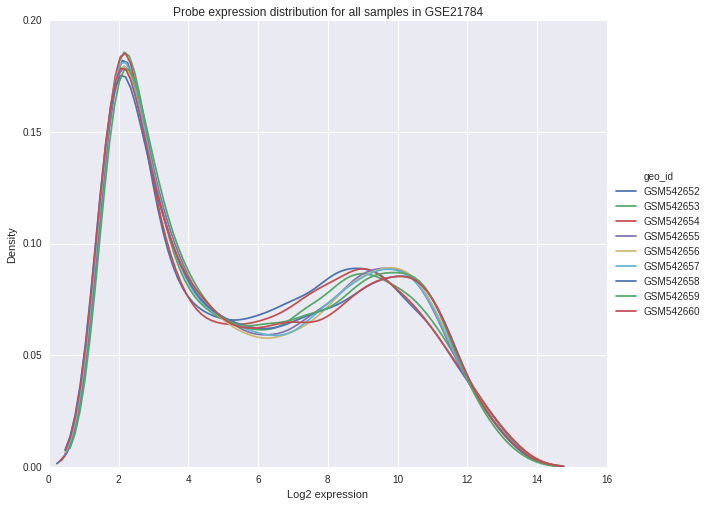

In [22]:
ax = plot_multi_density(
    exp_mjy, "geo_id", "log2_exp",
    rc = {"figure.figsize": (10, 8)}
)

ax.set_title("Probe expression distribution for all samples in GSE21784")
ax.set_xlabel("Log2 expression");

### Expression distribution for GSE77110

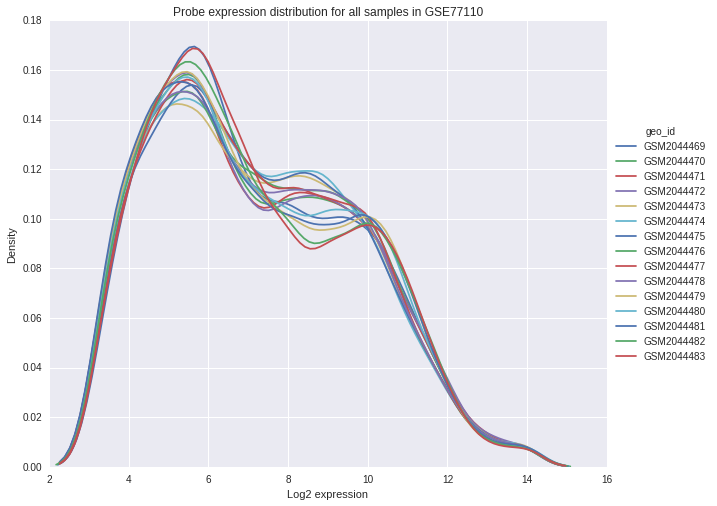

In [23]:
ax = plot_multi_density(
    exp_hou, "geo_id", "log2_exp",
    rc = {"figure.figsize": (10, 8)}
)

ax.set_title("Probe expression distribution for all samples in GSE77110")
ax.set_xlabel("Log2 expression");

The two expression distributions look quite different. There is a much more pronounced gap between the two peaks in GSE21784. In addition, the range in GSE21784 is slightly bigger (smallest expression is zero, compared to 2 in GSE77110).

GSE21784's samples also seem to perhaps be more similar to one another than the samples in GSE77110. These differences should again be comparable if we look at expression percentile instead of the actual expression value, since the dynamic range of these two datasets is again different.

### Expression distribution for PMID26623667

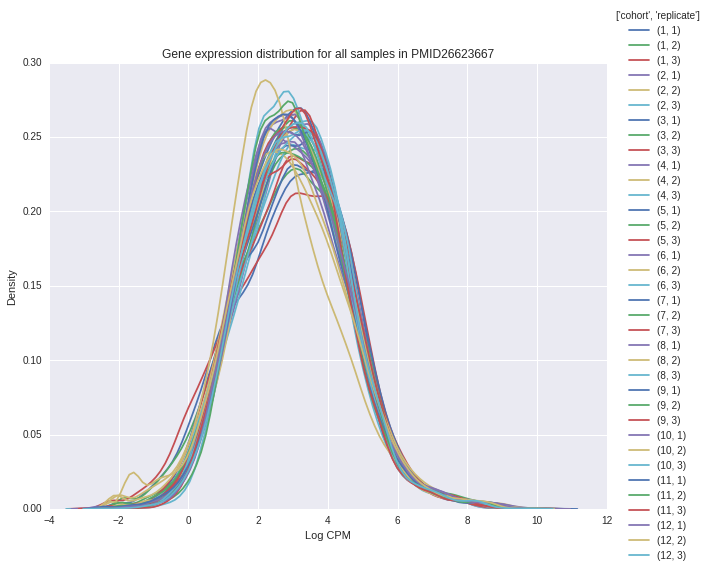

In [24]:
ax = plot_multi_density(
    mian, ["cohort", "replicate"], "log_cpm",
    rc = {"figure.figsize": (10, 8)}
)

ax.set_title("Gene expression distribution for all samples in PMID26623667")
ax.set_xlabel("Log CPM");

Sample 10 has the peak with the really downshifted peak. We will include everything for now, but may want to remove some outliers.

---

## Calculate expression percentile for each gene in its original sample

For each individual sample (GSM), calculate the expression percentile for each gene within that sample.

In [25]:
exp_mjy["sample_exp_ile"] = exp_mjy.groupby("geo_id")["log2_exp"].transform(calc_percentile)

exp_hou["sample_exp_ile"] = exp_hou.groupby("geo_id")["log2_exp"].transform(calc_percentile)

mian["sample_exp_ile"] = mian.groupby("samples")["log_cpm"].transform(calc_percentile)

Now that we have every gene's expression percentile in each sample, we should be able to combine the datasets together, since the genes have been normalized to themselves.

## Combine datasets together

We need to select the genes which are common to all datasets.

Some WormBase ids have multiple probes in GPL200. These likely represent different probes for different splice variants for the same gene. For now we will average across all of these probes as well, and then come back and decide if we should limit the search to genes with only one splice isoform.

In [26]:
common = set(mian["wormbase_id"]) & set(gpl200["wormbase_id"])
shared = gpl200.query("wormbase_id in @common")

print("There are {} common WormBase ids".format(len(common)))

There are 9544 common WormBase ids


### Filter the RNAseq data to common genes

In [27]:
mian = mian.query("wormbase_id in @common")

In [28]:
mian.groupby("samples")["wormbase_id"].nunique().value_counts()

9544    36
Name: wormbase_id, dtype: int64

We have reduced the mianserin data to 9544 genes per sample.

### Filter the array datasets to probes with WormBase ids common to all datasets

In [29]:
exp_hou = exp_hou.merge(shared, how = "right", on = "probe_id")
exp_mjy = exp_mjy.merge(shared, how = "right", on = "probe_id")

In [30]:
exp_hou.groupby("geo_id")["wormbase_id"].nunique().value_counts()

9544    15
Name: wormbase_id, dtype: int64

In [31]:
exp_mjy.groupby("geo_id")["wormbase_id"].nunique().value_counts()

9544    9
Name: wormbase_id, dtype: int64

## Join all three datasets together

In [32]:
comb = pd.concat(
    [
        exp_mjy[["wormbase_id", "geo_id", "sample_exp_ile"]],
        exp_hou[["wormbase_id", "geo_id", "sample_exp_ile"]],
        mian[["wormbase_id", "samples", "sample_exp_ile"]]
    ]
)

In [33]:
comb.shape

(643896, 4)

In [34]:
comb.head()

,geo_id,sample_exp_ile,samples,wormbase_id
0,GSM542652,72.994475,NaN,WBGene00013011
1,GSM542653,70.530387,NaN,WBGene00013011
2,GSM542654,73.496133,NaN,WBGene00013011
3,GSM542655,70.651934,NaN,WBGene00013011
4,GSM542656,73.666298,NaN,WBGene00013011


### Prepare gene names

In [35]:
names = pd.read_csv("../../data/id_maps/c_elegans.PRJNA13758.WS252.geneIDs.txt", sep = ',')

In [36]:
names.shape

(50930, 5)

In [37]:
names.head()

,taxon_id,wormbase_id,gene_symbol,orf_id,status
0,6239,WBGene00000001,aap-1,Y110A7A.10,Live
1,6239,WBGene00000002,aat-1,F27C8.1,Live
2,6239,WBGene00000003,aat-2,F07C3.7,Live
3,6239,WBGene00000004,aat-3,F52H2.2,Live
4,6239,WBGene00000005,aat-4,T13A10.10,Live


## Calculate mean and variance in expression across time

In [38]:
def calc(df, id_col, val_col):
    """Calculate mean and variance of a column."""
    
    # not sure how to deal with the multiindex stuff of doing a multiple aggregate...

    sub = df[[id_col, val_col]].groupby(id_col)

    return (
        pd.concat(
            [
                sub.mean().rename(columns = {val_col: "avg_{}".format(val_col)}),
                sub.var().rename(columns = {val_col: "var_{}".format(val_col)})
            ],
            axis = 1
        ).reset_index()
    )

In [39]:
res = (
    calc(comb, "wormbase_id", "sample_exp_ile")
        .assign(var_ile = lambda df: calc_percentile(df["var_sample_exp_ile"]))
        .merge(
            names[["wormbase_id", "gene_symbol", "orf_id"]],
            how = "left", on = "wormbase_id"
        )
        .sort_values(["var_sample_exp_ile", "avg_sample_exp_ile", "wormbase_id"])
        .reset_index(drop = True)
)

In [40]:
res.shape

(9544, 6)

In [41]:
res.head()

,wormbase_id,avg_sample_exp_ile,var_sample_exp_ile,var_ile,gene_symbol,orf_id
0,WBGene00004477,99.686990,0.005100,0.000000,rps-8,F42C5.8
1,WBGene00004416,99.761522,0.009507,0.010478,rpl-5,F54C9.5
2,WBGene00004497,99.756893,0.010638,0.020956,rps-28,Y41D4B.5
3,WBGene00009119,99.544836,0.014630,0.031433,ndk-1,F25H2.5
4,WBGene00004452,99.527559,0.015757,0.041911,rpl-38,C06B8.8


## Plot results

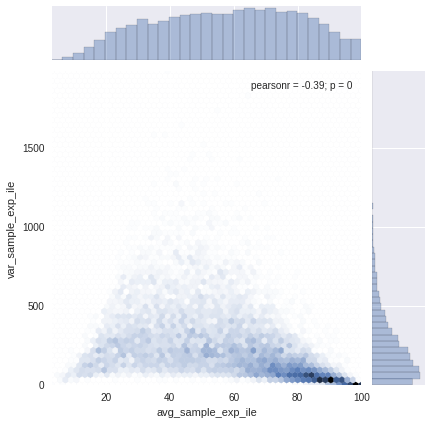

In [42]:
sns.jointplot(
    data = res,
    x = "avg_sample_exp_ile",
    y = "var_sample_exp_ile",
    kind = "hex"
);

Note how most of the genes lie in an arc below 500 variance. Some genes have very high variance, and the maximum variance seems to be highest in the middle expression percentiles. The effect is more clear when we also normalize the absolute variance value in terms of a percentile:

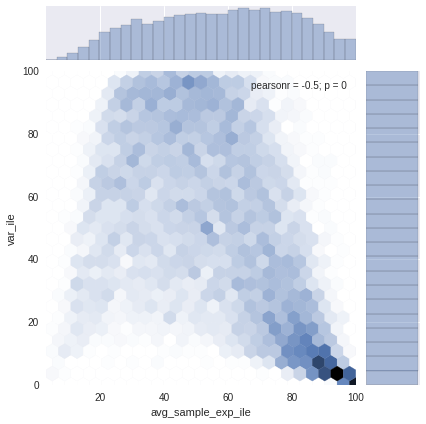

In [43]:
sns.jointplot(
    data = res,
    x = "avg_sample_exp_ile",
    y = "var_ile",
    kind = "hex"
);

It seems again that the vast majority of genes have relatively low variance in expression percentile across biological replicates, samples, biological conditions, and probes. This is good (and partially what we expect).

Note that it seems genes in the middle of the expression distribution seem to vary more than genes at either end of the expression distribution.

## Examine results

Let's examine the genes which drift the least, and have mean expression percentiles of 40 to 60%.

Number of genes: 2556


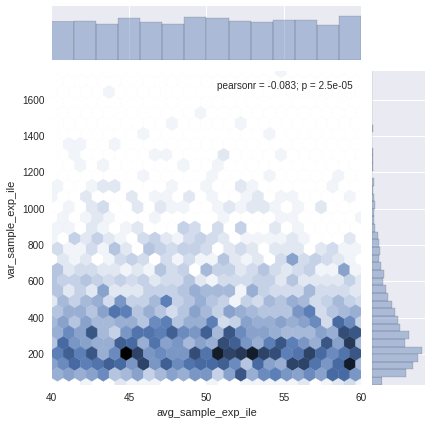

In [44]:
temp = res.query("40 < avg_sample_exp_ile < 60")
print("Number of genes: {}".format(len(temp)))

sns.jointplot(
    data = temp,
    x = "avg_sample_exp_ile",
    y = "var_sample_exp_ile",
    kind = "hex"
);

If we set the arbitrary variance threshold of 100, we get 178 genes:

Number of genes: 178


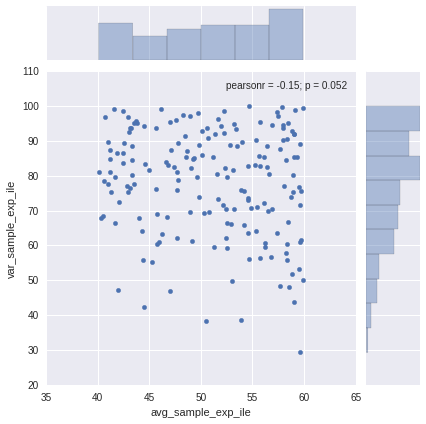

In [45]:
temp = res.query("40 < avg_sample_exp_ile < 60 & var_sample_exp_ile < 100")
print("Number of genes: {}".format(len(temp)))

sns.jointplot(
    data = temp,
    x = "avg_sample_exp_ile",
    y = "var_sample_exp_ile",
    kind = "scatter"
);

### Examine the genes directly:

In [46]:
# top 20 of 178 results
res.query("40 < avg_sample_exp_ile < 60 & var_sample_exp_ile < 100").head(20)

,wormbase_id,avg_sample_exp_ile,var_sample_exp_ile,var_ile,gene_symbol,orf_id
657,WBGene00017158,59.557143,29.294274,6.883906,hpo-10,F01F1.1
875,WBGene00011067,50.504975,38.443300,9.168064,vps-11,R06F6.2
883,WBGene00018269,53.848084,38.614899,9.251886,acs-11,F41C3.3
977,WBGene00000018,44.529599,42.285723,10.236798,abl-1,M79.1
1022,WBGene00010552,58.977436,43.811487,10.708298,NaN,K04C1.2
1095,WBGene00018781,46.993840,46.900286,11.473177,NaN,F54A3.2
1104,WBGene00003726,41.929755,47.328584,11.567477,nhr-136,C13C4.3
1114,WBGene00021497,58.553208,47.944453,11.672255,NaN,Y40C5A.4
1126,WBGene00003621,57.645248,48.320672,11.797988,nhr-22,K06A1.4
1162,WBGene00022300,53.048895,49.642963,12.175189,NaN,Y76B12C.6


### Examine a different expression range:

Number of genes: 1965


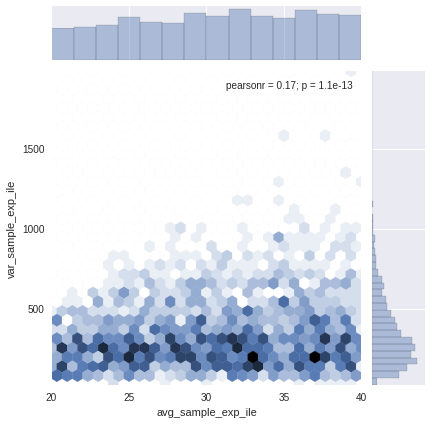

In [47]:
temp = res.query("20 < avg_sample_exp_ile < 40")
print("Number of genes: {}".format(len(temp)))

sns.jointplot(
    data = temp,
    x = "avg_sample_exp_ile",
    y = "var_sample_exp_ile",
    kind = "hex"
);

Again setting an arbitrary threshold of < 100 variance:

Number of genes: 108


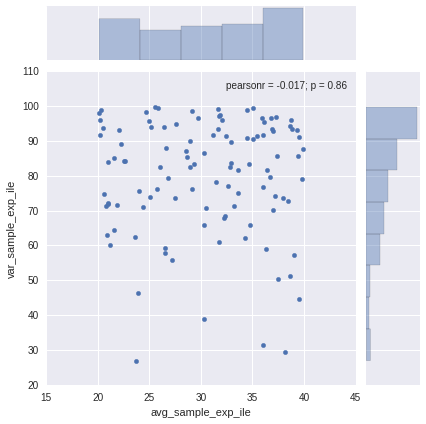

In [48]:
temp = res.query("20 < avg_sample_exp_ile < 40 & var_sample_exp_ile < 100")
print("Number of genes: {}".format(len(temp)))

sns.jointplot(
    data = temp,
    x = "avg_sample_exp_ile",
    y = "var_sample_exp_ile",
    kind = "scatter"
);

In [49]:
# top 20 of 108 results
res.query("20 < avg_sample_exp_ile < 40 & var_sample_exp_ile < 100").head(20)

,wormbase_id,avg_sample_exp_ile,var_sample_exp_ile,var_ile,gene_symbol,orf_id
604,WBGene00001022,23.701396,26.946641,6.328583,dnj-4,C01G8.4
660,WBGene00016865,38.141605,29.447973,6.915339,ets-9,C52B9.2
705,WBGene00015115,36.026743,31.418538,7.386840,NaN,B0286.1
887,WBGene00016559,30.293478,38.744172,9.293797,NaN,C41A3.2
1036,WBGene00019326,39.539698,44.535669,10.854987,NaN,K02F3.2
1084,WBGene00022103,23.945737,46.476797,11.357921,cdh-12,Y71D11A.1
1179,WBGene00007602,37.462573,50.285624,12.353311,NaN,C15C6.3
1197,WBGene00010367,38.684667,51.099981,12.541911,NaN,H05L14.2
1314,WBGene00013789,27.196676,55.936560,13.767812,NaN,Y116A8C.9
1352,WBGene00003685,39.037018,57.129180,14.165968,nhr-95,Y39B6A.17


## Save full results to file

In [50]:
res.to_csv("full_constant_exp_genes.tsv", sep = '\t', index = False)

## Conclusions

We have made our predictions of the least variable genes in these three datasets. We now pass the data back to Michael so that he can test them in the lab.